# Simple Clustering Examples

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**SA Clustering classes**

All clustering classes and functions are located in the package `clustering`

The module `sa` contains the classes for simulated annealing.  At the moment this splits
the problem up into a `CoolingSchedule` (the class `CoruCoolingSchedule` is the port from Matlab) and `SACluster`

The class `SACluster` has an interface that gives a similar look and feel to `sklearn.KMeans`

In [2]:
from clustering.sa import SACluster, ExponentialCoolingSchedule, CoruCoolingSchedule

In [3]:
sns.set_style('whitegrid')

## 1. Mall Customers Example - toy 2D clustering dataset

In [4]:
df = pd.read_csv('data/Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Pre-Process Dataset

In [5]:
unlabelled_x = df.iloc[:, [3, 4]].values
unlabelled_x.shape

(200, 2)

## K-means example

In [71]:
def elbow_wcss(unlabelled_x, min_clusters=1, max_clusters=10):
    '''
    Graphical approach to estimating the number of 
    cluster to optimise K for the kmeans clustering.
    
    Returns:
    List containing the weighted cluster sum of squares for
    k between min_clusters and max_clusters
    
    Keyword arguments:
    unlabelled_x -- numpy.ndarray of unlabelled data
    min_clusters -- min k (default = 1)
    max_clusters -- max k (default = 10)
    '''
    #weighted sum of squares
    wcss = []

    for k in range(min_clusters, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(unlabelled_x)
        wcss.append(kmeans.inertia_)
        
    return wcss

In [72]:
def plot_elbow(wcss, min_clusters=1):
    plt.plot(range(min_clusters, min_clusters+len(wcss)), wcss, 'bo-')
    plt.xlabel('K')
    plt.ylabel('Weighted Cluster Sum of Squares')
    plt.title('K-means Elbow Plot')
    plt.show()

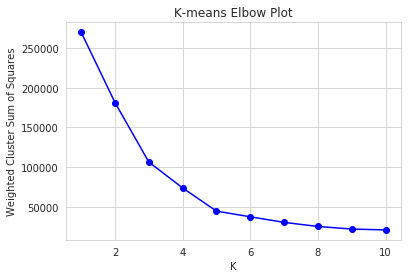

In [73]:
wcss = elbow_wcss(unlabelled_x)
plot_elbow(wcss)

### Cluster by optimal k

In [74]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=101)
pred = kmeans.fit_predict(unlabelled_x)

In [75]:
df_pred = pd.DataFrame(unlabelled_x, columns=['annual_income', 'spending_score'])
df_pred['cluster'] = pred
df_pred.head()

,annual_income,spending_score,cluster
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3
4,17,40,4


In [76]:
def plot_clusters(data, kmeans, min_clusters, max_clusters, colours):
    
    plt.figure(figsize=(10,6))
    
    for k in range(max_clusters):
        cluster_data = data.loc[data['cluster'] == k]
        plt.scatter(x='annual_income', y='spending_score', data=cluster_data, 
                    label='Cluster ' + str(k+1), c=colours[k])
        
    plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], s=300, 
                c='black', label='Centroids', marker='+')

    
    plt.xlabel('annual income ($k)')
    plt.ylabel('spending score (0-100)')
    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    #       ncol=4, mode='expand', borderaxespad=0.)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

In [77]:
df_pred.values.shape

(200, 3)

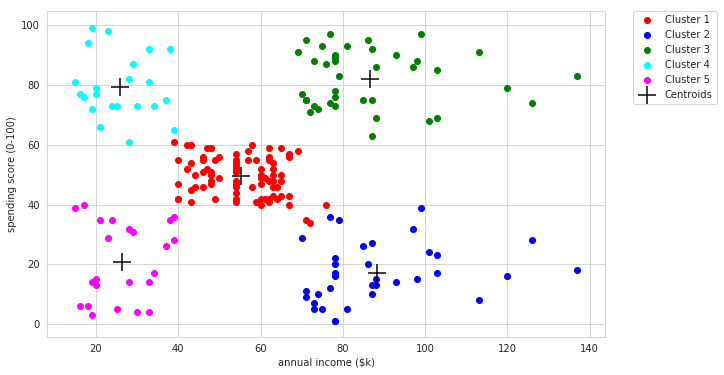

In [78]:
colours = ['red', 'blue', 'green', 'cyan', 'magenta', 'orange', 'yellow']
plot_clusters(df_pred, kmeans, 1, optimal_k, colours)

### Results from running MatLab code on same data with 5 clusters

The same data was run on the MatLab code.  The solution is very similar.  No objective measure used, but looks **at least** as good as kmeans

In [91]:
def plot_clusters_mat(data, min_clusters, max_clusters, colours):
    
    plt.figure(figsize=(10,6))
    
    for k in range(max_clusters):
        cluster_data = data.loc[data['cluster'] == k+1]
        plt.scatter(x='annual_income', y='spending_score', data=cluster_data, 
                    label='Cluster ' + str(k+1), c=colours[k])
    
    plt.xlabel('annual income ($k)')
    plt.ylabel('spending score (0-100)')


    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

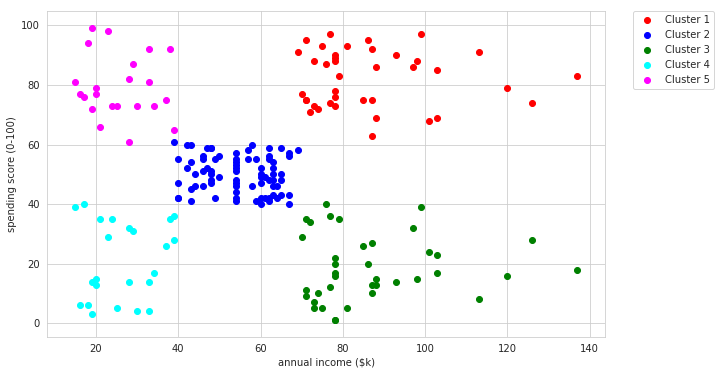

In [92]:
arr = np.genfromtxt('data/matlab_output.csv')
df_pred_mat = pd.DataFrame(unlabelled_x, columns=['annual_income', 'spending_score'])
df_pred_mat['cluster'] = arr
plot_clusters_mat(df_pred_mat, 1, optimal_k, colours)

## Simulated Annealing Example

* Python port of MatLab code

In [106]:
n_clusters = 5
max_iter = max(10 * unlabelled_x.shape[0], 10000)
cooling_schedule = CoruCoolingSchedule(1000, max_iter=max_iter)
#cooling_schedule = ExponentialCoolingSchedule(1000)
sa = SACluster(n_clusters=n_clusters, cooling_schedule=cooling_schedule,
               dist_metric='euclidean', max_iter=max_iter, random_state=101)

In [107]:
%%time
state, energy = sa.fit(unlabelled_x)

CPU times: user 1.1 s, sys: 3.93 ms, total: 1.11 s
Wall time: 1.1 s


In [108]:
energy

1765.47221894258

In [109]:
pd.DataFrame(sa.search_history).tail()

,0
9995,1765.472219
9996,1765.472219
9997,1765.472219
9998,1765.472219
9999,1765.472219


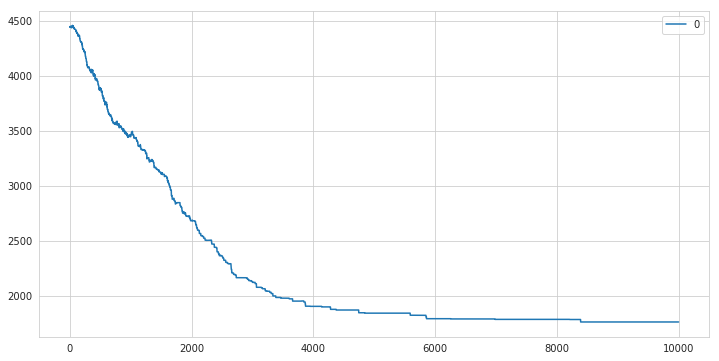

In [110]:
pd.DataFrame(sa.search_history).plot(figsize=(12,6))

In [88]:
df_pred_sa = pd.DataFrame(unlabelled_x, columns=['annual_income', 'spending_score'])
df_pred_sa['cluster'] = state
df_pred_sa.head()

,annual_income,spending_score,cluster
0,15,39,3
1,15,81,1
2,16,6,3
3,16,77,1
4,17,40,3


In [89]:
def plot_clusters_sa(data, min_clusters, max_clusters, colours):
    
    plt.figure(figsize=(10,6))
    
    for k in range(max_clusters):
        cluster_data = data.loc[data['cluster'] == k]
        plt.scatter(x='annual_income', y='spending_score', data=cluster_data, 
                    label='Cluster ' + str(k+1), c=colours[k])
        
    #plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], s=300, 
    #            c='black', label='Centroids', marker='+')

    
    plt.xlabel('annual income ($k)')
    plt.ylabel('spending score (0-100)')
    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
    #       ncol=4, mode='expand', borderaxespad=0.)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

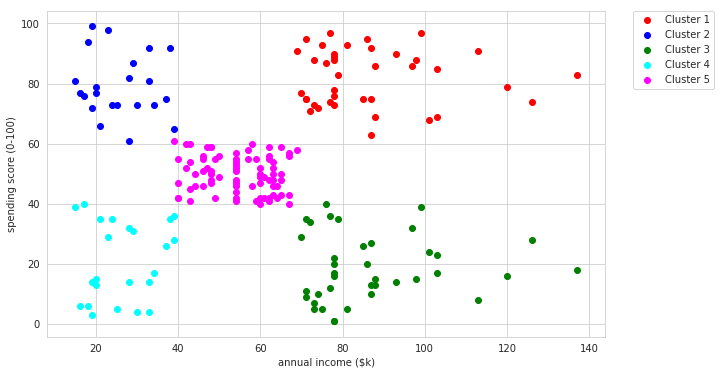

In [90]:
plot_clusters_sa(df_pred_sa, 1, optimal_k, colours)